In [48]:
import pickle
league_result_path = 'league_results_eg_cont_quick.pkl'
with open(league_result_path, 'rb') as f:
    league_results = pickle.load(f)
    
league_results.keys()
modified_league_results = {}
for agent_1_and_agent_2, results in league_results.items():
    agent_1_name = agent_1_and_agent_2.split('___')[0]
    agent_2_name = agent_1_and_agent_2.split('___')[1]
    if 'Always Cooperate' in agent_1_name:
        agent_1_name = 'Always Cooperate'
    if 'Always Defect' in agent_1_name:
        agent_1_name = 'Always Defect'
    if 'Always Cooperate' in agent_2_name:
        agent_2_name = 'Always Cooperate'
    if 'Always Defect' in agent_2_name:
        agent_2_name = 'Always Defect'
    modified_league_results[(agent_1_name, agent_2_name)] = results

league_results = modified_league_results
league_results.keys()

dict_keys([('advantage_alignment_42', 'advantage_alignment_42'), ('advantage_alignment_42', 'advantage_alignment_43'), ('advantage_alignment_42', 'advantage_alignment_44'), ('advantage_alignment_42', 'advantage_alignment_45'), ('advantage_alignment_42', 'advantage_alignment_46'), ('advantage_alignment_42', 'advantage_alignment_47'), ('advantage_alignment_42', 'advantage_alignment_48'), ('advantage_alignment_42', 'advantage_alignment_49'), ('advantage_alignment_42', 'advantage_alignment_50'), ('advantage_alignment_42', 'advantage_alignment_51'), ('advantage_alignment_42', 'ppo_42'), ('advantage_alignment_42', 'ppo_43'), ('advantage_alignment_42', 'ppo_44'), ('advantage_alignment_42', 'ppo_45'), ('advantage_alignment_42', 'ppo_46'), ('advantage_alignment_42', 'ppo_47'), ('advantage_alignment_42', 'ppo_48'), ('advantage_alignment_42', 'ppo_49'), ('advantage_alignment_42', 'ppo_50'), ('advantage_alignment_42', 'ppo_51'), ('advantage_alignment_42', 'ppo-sum-rewards_42'), ('advantage_alignme

In [49]:
from typing import List
from matplotlib.colors import ListedColormap
import numpy as np
import matplotlib.pyplot as plt
from matplotlib.tri import Triangulation

def plot_league_result_custom_columns(league_result,
                       agent_clean_names,
                       name_to_plot_name,
                       row_names, 
                       column_names,
                       fig_size: int,
                       ):
    """
    Plot the league result as a heatmap
    league_result: a dictionary of the form {(agent_1, agent_2): (agent_1_num, agent_2_num)}
    """


    # Create a custom colormap
    cmap = 'RdYlGn'
    
    def get_game_result(a1_name, a2_name):
        if a2_name == 'Self':
            return league_result[(a1_name, a1_name)] if (a1_name, a1_name) in league_result else (np.nan, np.nan)
        if a1_name == 'Self':
            return league_result[(a2_name, a2_name)] if (a2_name, a2_name) in league_result else (np.nan, np.nan)
        return league_result[(a1_name, a2_name)] if (a1_name, a2_name) in league_result else (np.nan, np.nan)

    M = len(row_names)
    N = len(column_names)
    x = np.arange(M + 1) # 0, 1, ..., M
    y = np.arange(N + 1) # 0, 1, ..., N
    xs, ys = np.meshgrid(x, y) # (N+1, M+1)
    zs_1 = [get_game_result(agent_1, agent_2)[0] for agent_1 in column_names for agent_2 in row_names]
    zs_2 = [get_game_result(agent_1, agent_2)[1] for agent_1 in column_names for agent_2 in row_names]
    zs_1 = np.array(zs_1)
    zs_2 = np.array(zs_2)
    print(f'zs_1.shape: {zs_1.shape}, zs_2.shape: {zs_2.shape}')

    fig, ax = plt.subplots(figsize=(fig_size, fig_size))
    from mpl_toolkits.axes_grid1 import make_axes_locatable
    divider = make_axes_locatable(ax)
    cax1 = divider.append_axes('right', size='5%', pad=0.1)

    triangles1 = [(i + j*(M+1), i + (j+1)*(M+1), i+1 + (j+1)*(M+1)) for j in range(N) for i in range(M)] # (i, j) (i, j+1) (i+1, j+1)
    triangles2 = [(i + j*(M+1), i+1 + (j)*(M+1), i + 1 + (j+1)*(M+1)) for j in range(N) for i in range(M)] # (i, j) (i+1, j) (i+1, j+1)
    triang1 = Triangulation(xs.ravel(), ys.ravel(), triangles1)
    triang2 = Triangulation(xs.ravel(), ys.ravel(), triangles2)
    plt.rcParams['axes.grid'] = False
    img1 = ax.tripcolor(triang1, zs_1, cmap=plt.get_cmap(cmap, 100), vmin=0.2, vmax=0.5)
    img2 = ax.tripcolor(triang2, zs_2, cmap=plt.get_cmap(cmap, 100), vmin=0.2, vmax=0.5)
    plt.colorbar(img1, ticks=np.arange(0.2, 0.5, 0.05), cax=cax1)
    # add title for the colorbar
    cax1.set_title('Return', fontsize=30)
    # increase colorbar tick font size
    cax1.tick_params(labelsize=20)

    # write text
    if True:
        for i in range(M):
            for j in range(N):
                if f'{zs_1[i + j * M]}' != 'nan':
                    ax.text(i+0.25, j+0.75, f'{zs_1[i + j*M]:.2f}', ha='center', va='center', fontsize=20, color='black')
                    ax.text(i+0.75, j+0.25, f'{zs_2[i + j*M]:.2f}', ha='center', va='center', fontsize=20, color='black')

    ax.set_xlim(x[0], x[-1])
    ax.set_ylim(y[0], y[-1])
    ax.set_xticks(x[:-1]+0.5)
    clean_names = [name_to_plot_name[name] for name in row_names]
    ax.set_xticklabels(clean_names, rotation=60, fontsize=20)
    clean_names = [name_to_plot_name[name] for name in column_names]
    ax.set_yticks(y[:-1]+0.5)
    ax.set_yticklabels(clean_names, fontsize=20)
    # make it square
    ax.set_aspect('equal', 'box')
    ax.xaxis.tick_top()
    ax.invert_yaxis()

advantage_alignment_42 vs advantage_alignment_42 -> advantage_alignment vs advantage_alignment
advantage_alignment_42 vs advantage_alignment_43 -> advantage_alignment vs advantage_alignment
advantage_alignment_42 vs advantage_alignment_44 -> advantage_alignment vs advantage_alignment
advantage_alignment_42 vs advantage_alignment_45 -> advantage_alignment vs advantage_alignment
advantage_alignment_42 vs advantage_alignment_46 -> advantage_alignment vs advantage_alignment
advantage_alignment_42 vs advantage_alignment_47 -> advantage_alignment vs advantage_alignment
advantage_alignment_42 vs advantage_alignment_48 -> advantage_alignment vs advantage_alignment
advantage_alignment_42 vs advantage_alignment_49 -> advantage_alignment vs advantage_alignment
advantage_alignment_42 vs advantage_alignment_50 -> advantage_alignment vs advantage_alignment
advantage_alignment_42 vs advantage_alignment_51 -> advantage_alignment vs advantage_alignment
advantage_alignment_42 vs ppo_42 -> advantage_alig

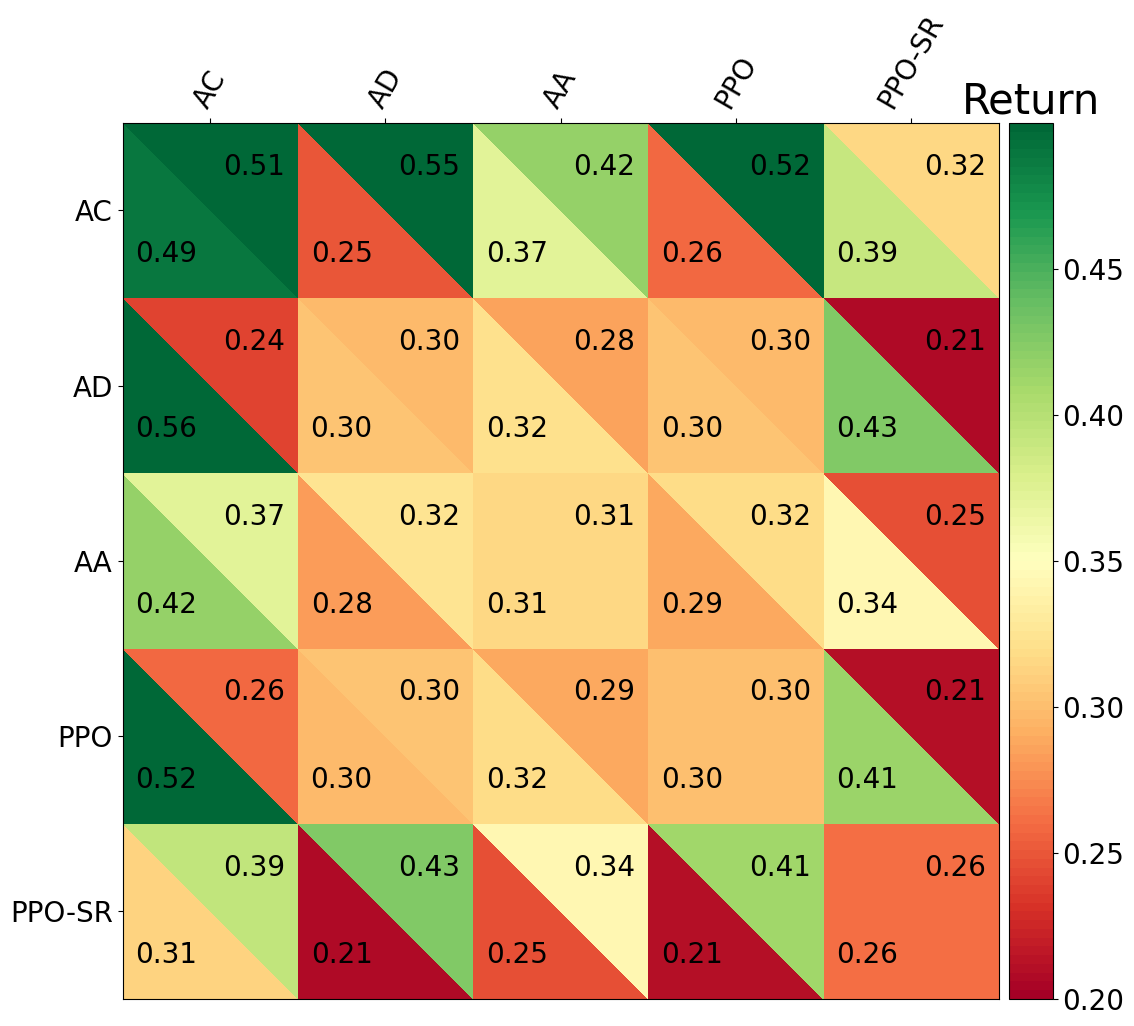

In [50]:
from collections import defaultdict
import numpy as np
aggregate_config = {
    'advantage_alignment': [f'advantage_alignment_{seed}' for seed in [42, 43, 44, 45, 46, 47, 48, 49, 50, 51]],
    'ppo': [f'ppo_{seed}' for seed in [42, 43, 44, 45, 46, 47, 48, 49, 50, 51]],
    'ppo-sum-rewards': [f'ppo-sum-rewards_{seed}' for seed in [42, 43, 44, 45, 46, 47, 48, 49, 50, 51]],
    'Always Cooperate': ['Always Cooperate'],
    'Always Defect': ['Always Defect'],
}

agent_clean_names = [
 'Always Cooperate',
 'Always Defect',
 'advantage_alignment',
 'ppo',
 'ppo-sum-rewards',
]

name_to_plot_name = {
'Always Cooperate': 'AC',
'Always Defect': 'AD',
'advantage_alignment': 'AA',
'ppo': 'PPO',
'ppo-sum-rewards': 'PPO-SR',
}

return_matrix = {}
for k, v in league_results.items():
    return_matrix[k] = np.stack([v.data['rewards_0'].mean().numpy(),
                                      v.data['rewards_1'].mean().numpy()])
    
    # fill in the missing entries
all_agent_names = [k1 for k1, k2 in return_matrix.keys()] + [k2 for k1, k2 in return_matrix.keys()]
agent_names = all_agent_names
agent_names = sorted(list(agent_names))
for agent_1 in agent_names:
    for agent_2 in agent_names:
        if (agent_1, agent_2) not in return_matrix:
            if (agent_2, agent_1) in return_matrix:
                ret = return_matrix[(agent_2, agent_1)]
                return_matrix[(agent_1, agent_2)] = (ret[1], ret[0])
            else:
                return_matrix[(agent_1, agent_2)] = (np.nan, np.nan)

# aggregating
def find_umbrella(agent_name, aggregate_config):
    for k, v in aggregate_config.items():
        if agent_name in v:
            return k
    raise ValueError(f'umbrella not found for {agent_name}')

final_matrix = {}
agg_matrix = defaultdict(list)
for k, v in return_matrix.items():
    agent_1, agent_2 = k
    umbrella_1 = find_umbrella(agent_1, aggregate_config)
    umbrella_2 = find_umbrella(agent_2, aggregate_config)
    print(f'{agent_1} vs {agent_2} -> {umbrella_1} vs {umbrella_2}')
    agg_matrix[(umbrella_1, umbrella_2)].append(v)

for k, v in agg_matrix.items():
    final_matrix[k] = np.mean(v, axis=0)
    print(f'{k}: {len(v)} samples, v:{v} v_mean: {final_matrix[k]}')
    print('='*20)

return_matrix = final_matrix


plot_league_result_custom_columns(return_matrix, 
                                  agent_clean_names,
                                  name_to_plot_name,
                                  row_names = agent_clean_names,
                                  column_names=agent_clean_names,
                                  fig_size=12)
# save the figure to pdf
plt.savefig('league_result.pdf', bbox_inches='tight')
plt.show()

In [41]:
v = league_results[('ppo_42','ppo-sum-rewards_42')]

np.stack([v.data['rewards_0'].mean().numpy(),
               v.data['rewards_1'].mean().numpy()])

KeyError: ('ppo_42', 'ppo-sum-rewards_42')